## SAS Tip Tuesday: Submit SAS Code with SASPy
*03/11/2025*

- *Stu Sztukowski*
- *https://linkedin.com/in/StatsGuy* | *https://github.com/stu-code*

***

One great thing about SASPy is that it also lets you run arbitrary SAS code. It's as easy as starting a connection and running sas.submit(). You can get output in list or HTML - your choice! With IPython.display you can easily display the returned ODS output if needed.

When you're working with SASPy, you're in a full SAS session. This means you can do anything SAS can do:
- Run SQL queries
- Run the DATA Step
- Run PROCs
- Create libraries
- Connect to CAS
- Run CAS Actions with PROC CAS
- etc.

In [1]:
import saspy
from IPython.display import HTML

## Start a SAS session

You can configure the connection types you want within ~./config/saspy/sascfg_personal.py. 

We'll start a local connection to SAS installed on a local Windows machine, but you can easily connect to SAS Viya, SAS Grid, SAS Mainframe, or a remote SAS server. 

For more information on how to change how you connect to SAS, see:
https://sassoftware.github.io/saspy/getting-started.html#start-a-sas-session

In [2]:
sas = saspy.SASsession(cfgname='winlocal')

SAS Connection established. Subprocess id is 16304



## Try running some SAS code

Now that we have started a SAS session, we can run SAS any way we'd like. Let's run some SAS code directly to import data from a URL and print it.

In [3]:
res = sas.submit(code=
'''
filename in url "https://github.com/stu-code/sas-tips/raw/refs/heads/main/data/insurance.csv";

proc import
    file=in
    out=insurance
    dbms=csv
    replace;
run;
'''
)

# Checking the log

Now we've imported our data as work.insurance. To confirm this, you can easily check the log by printing sas.lastlog()

In [4]:
print(sas.lastlog())

5                                                          The SAS System                        Tuesday, March 11, 2025 04:21:00 PM

24         ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;
24       ! ods graphics on / outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: _TOMODS1
25         
26         
27         filename in url "https://github.com/stu-code/sas-tips/raw/refs/heads/main/data/insurance.csv";
28         
29         proc import
30             file=in
31             out=insurance
32             dbms=csv
33             replace;
34         run;

35          /**********************************************************************
36          *   PRODUCT:   SAS
37          *   VERSION:   9.4
38          *   CREATOR:   External File Interface
39          *   DATE:      11MAR25
40          *   DESC:      Generated SAS Datastep Code
41          *   TEMPLATE SOURCE:  (None Specified.)
42          **

# Displaying Output

Let's print the first 10 observations using PROC PRINT. We'll specify that we want HTML output and print it so it looks nice. Since it comes back as HTML, we'll need to use the HTML function to see it from IPython.display.

To get the results, use `res['LST']`

In [5]:
res = sas.submit(code=
'''
proc print data=insurance(obs=10);
run;
'''
)

HTML(res['LST'])

Obs,age,sex,bmi,children,smoker,region,charges
1,19,female,27.9,0,yes,southwest,16884.924
2,18,male,33.77,1,no,southeast,1725.5523
3,28,male,33,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.47061
5,32,male,28.88,0,no,northwest,3866.8552
6,31,female,25.74,0,no,southeast,3756.6216
7,46,female,33.44,1,no,southeast,8240.5896
8,37,female,27.74,3,no,northwest,7281.5056
9,37,male,29.83,2,no,northeast,6406.4107
10,60,female,25.84,0,no,northwest,28923.13692


# What about PROCs?

Of course! You can view all of the output from a PROC. Check out the results from GLMSELECT.

Data Set,WORK.INSURANCE
Dependent Variable,charges
Selection Method,Stepwise
Select Criterion,Significance Level
Stop Criterion,Significance Level
Choose Criterion,Adj R-Sq
Entry Significance Level (SLE),0.1
Stay Significance Level (SLS),0.05
Effect Hierarchy Enforced,None
Number of Observations Read,1338
Number of Observations Used,1338

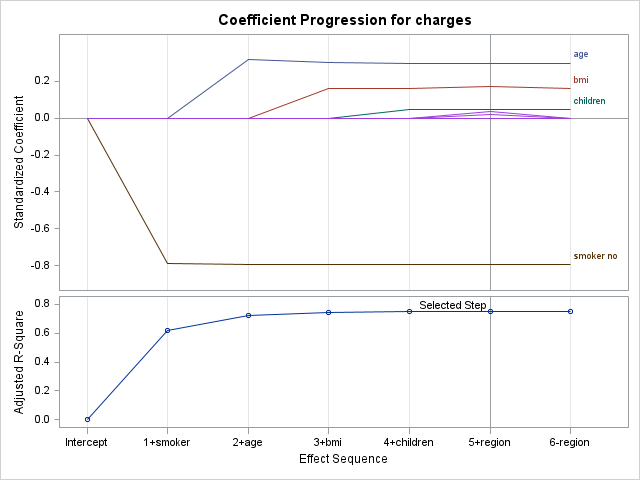
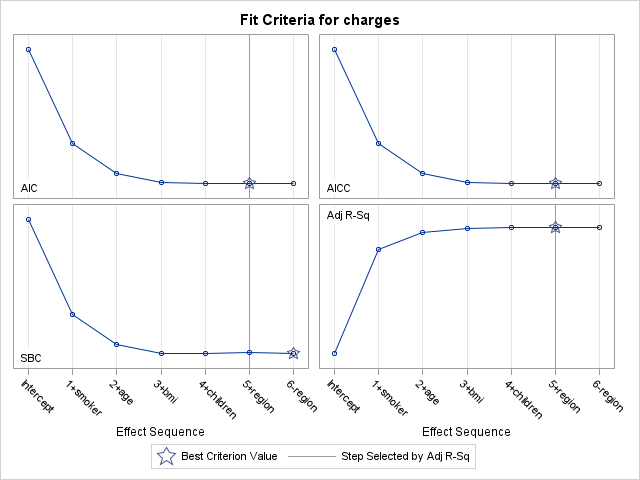
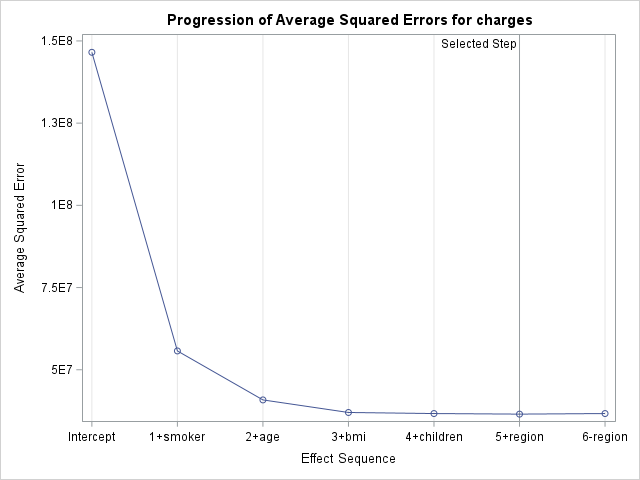

In [6]:
res = sas.submit(
'''
proc glmselect data=insurance plots=all;
    class sex smoker region;
    model charges = age sex bmi children smoker region 
        / selection=stepwise(select=sl choose=adjrsq sle=0.1 sls=0.05) 
          showpvalues;
run;
'''
)

HTML(res['LST'])

# Data Manipulation: DATA Step and SQL

With sas.submit, you can do data manipulation with the DATA Step and SQL - whichever you like, in any order you like. You can mix and match Python and SAS. There is no limit to what order you do things and in what language you decide to do them.

In [7]:
res = sas.submit(code=
'''
data insurance2;
    set insurance;
    sex     = upcase(sex);
    region  = upcase(region);
    charges = round(charges);
run;
'''
)

In [8]:
insurance2 = sas.sasdata('insurance2')
insurance2.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,FEMALE,27.900,0.0,yes,SOUTHWEST,16885.0
1,18.0,MALE,33.770,1.0,no,SOUTHEAST,1726.0
2,28.0,MALE,33.000,3.0,no,SOUTHEAST,4449.0
3,33.0,MALE,22.705,0.0,no,NORTHWEST,21984.0
4,32.0,MALE,28.880,0.0,no,NORTHWEST,3867.0


In [9]:
res = sas.submit(code=
'''
proc sql;
    create table us_counties as
        select t1.id as county_id
             , t2.idname as county 
             , t1.county as county_id
             , t1.statecode
             , t1.x
             , t1.y
        from mapsgfk.us_counties as t1
        LEFT JOIN
             mapsgfk.us_counties_attr as t2
        ON t1.id = t2.id
    ;
quit;
'''              
)

In [10]:
us_counites = sas.sasdata('us_counties')
us_counites.head()

,county_id,county,STATECODE,X,Y
0,US-01001,Autauga,AL,-672.396881,499.598259
1,US-01001,Autauga,AL,-672.370142,492.022205
2,US-01001,Autauga,AL,-672.329723,488.538197
3,US-01001,Autauga,AL,-672.809920,488.259521
4,US-01001,Autauga,AL,-673.355894,488.169566
